## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import importlib
import sys
import numpy as np
import torch
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 24000

#### Load model from checkpoint

In [4]:
import train
importlib.reload(train)
from train import load_model

# checkpoint_path = "outdir_only_qust_token/checkpoint_44000"
checkpoint_path = "outdir_embedding_decoder_add_npy/checkpoint_48000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis

In [6]:
from parallel_wavegan.utils import load_model
vocoder = load_model("/data1/baibing/.cache/parallel_wavegan/can700_multi_band_melgan.v2/checkpoint-1450000steps.pkl").to("cuda").eval()

#### Prepare text input

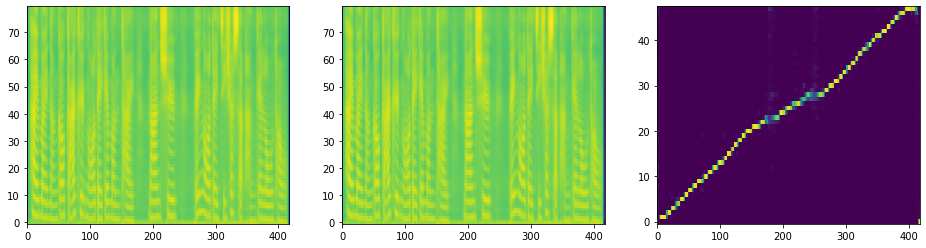

5.225


In [11]:
# text = "z ek3 d aai6 b an6 z oeng6 h ai6 b ei2 z i6 g ei2 g e3 z aap6 gw aan3 t ung4 m aai4 g au6 s i1 s oeng2 s o2 c uk1 b ok3 g aa2"
# text = "m ei6 l oi4 s ap6 n in4 n e1 g o3 d ei6 f ong1 z an1 h ai6 w ui6 j au5 j an4 f aat3 z in2"
text = "h ai6 m ai4 n ang4 g au3 g aai2 k yut3 ng o5 d ei6 g e3 m an6 t ai4 <space> n aan6 s yu3 <space> b ei2 ng o5 d ei6 z i2 c eot1 s at6 h ang4 g e3 l ou6 t ou4"

sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
type_scalar = torch.LongTensor([1])
type_sequence = type_scalar.expand_as(sequence).cuda()
inputs = (sequence, type_sequence)

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(inputs)
mel_outputs = mel_outputs.float().data.cpu().numpy()[0]
mel_outputs_postnet= mel_outputs_postnet.float().data.cpu().numpy()[0]
alignments = alignments.float().data.cpu().numpy()[0].T
plot_data((mel_outputs,
           mel_outputs_postnet,
           alignments))
plt.show()

with torch.no_grad():
    y = vocoder.inference(mel_outputs_postnet.T)
    audio = y.view(-1).cpu().numpy()
print(audio.shape[0]/hparams.sampling_rate)
ipd.Audio(audio, rate=hparams.sampling_rate)